In [27]:
import pandas as pd
import requests
import time
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [28]:

# CONFIGURATION
ETHERSCAN_API_KEY = 'YA6KJN17VCWEAD9NR2Q4BT2FG29WAC6JCW'
ETHERSCAN_BASE_URL = 'https://api.etherscan.io/api'
COMPOUND_V2_GRAPH = 'https://api.thegraph.com/subgraphs/name/graphprotocol/compound-v2'
COMPOUND_V3_GRAPH = 'https://api.thegraph.com/subgraphs/name/compound-finance/compound-v3'



In [29]:

wallet_df = pd.read_csv("/content/Wallet id - Sheet1.csv")
wallets = wallet_df['wallet_id'].tolist()


In [30]:
# ETHERSCAN TX + TOKEN STATS

def get_transactions(wallet):
    url = f"{ETHERSCAN_BASE_URL}?module=account&action=txlist&address={wallet}&startblock=0&endblock=99999999&sort=asc&apikey={ETHERSCAN_API_KEY}"
    try:
        response = requests.get(url)
        data = response.json()
        if data.get("status") == "1":
            return data.get("result", [])
        return []
    except:
        return []

In [31]:
def analyze_etherscan(wallet, txs):
    num_txs = len(txs)
    incoming = sum(1 for tx in txs if tx["to"].lower() == wallet.lower())
    outgoing = sum(1 for tx in txs if tx["from"].lower() == wallet.lower())
    total_in_eth = sum(int(tx["value"]) for tx in txs if tx["to"].lower() == wallet.lower()) / 1e18
    total_out_eth = sum(int(tx["value"]) for tx in txs if tx["from"].lower() == wallet.lower()) / 1e18
    avg_tx_value_eth = (total_in_eth + total_out_eth) / num_txs if num_txs > 0 else 0

    return {
        "num_txs": num_txs,
        "total_out_eth": total_out_eth,
        "avg_tx_value_eth": avg_tx_value_eth
    }

def get_token_transfers(wallet):
    url = f"{ETHERSCAN_BASE_URL}?module=account&action=tokentx&address={wallet}&startblock=0&endblock=99999999&sort=asc&apikey={ETHERSCAN_API_KEY}"
    try:
        response = requests.get(url)
        data = response.json()
        txs = data.get("result", [])
        total_tokens = sum(
            float(tx.get("value", 0)) / 10**int(tx.get("tokenDecimal", 18)) for tx in txs
            if tx["to"].lower() == wallet.lower()
        )
        return {"total_token_received": total_tokens}
    except:
        return {"total_token_received": 0}


In [32]:
# COMPOUND V2 DATA

def get_compound_v2_data(wallet):
    query = f"""
    {{
      account(id: "{wallet.lower()}") {{
        tokens {{
          supplyBalanceUnderlying
          borrowBalanceUnderlying
        }}
      }}
    }}
    """
    try:
        response = requests.post(COMPOUND_V2_GRAPH, json={"query": query})
        account = response.json().get("data", {}).get("account", {})
        tokens = account.get("tokens", []) if account else []
    except:
        tokens = []

    supply = sum(float(t.get("supplyBalanceUnderlying", 0)) for t in tokens)
    borrow = sum(float(t.get("borrowBalanceUnderlying", 0)) for t in tokens)
    collateral_ratio = supply / borrow if borrow > 0 else 1

    return {
        "compound_supply": supply,
        "compound_borrow": borrow,
        "compound_collateral_ratio": collateral_ratio
    }

def get_liquidation_count(wallet):
    query = f"""
    {{
      liquidationEvents(where: {{borrower: "{wallet.lower()}"}}) {{
        id
      }}
    }}
    """
    try:
        response = requests.post(COMPOUND_V2_GRAPH, json={"query": query})
        events = response.json().get("data", {}).get("liquidationEvents", [])
        return {"liquidation_count": len(events)}
    except:
        return {"liquidation_count": 0}

In [33]:
# COMPOUND V3 DATA

def get_compound_v3_data(wallet):
    query = f"""
    {{
      account(id: "{wallet.lower()}") {{
        totalCollateralValueUSD
        totalBorrowValueUSD
        healthScore
      }}
    }}
    """
    try:
        response = requests.post(COMPOUND_V3_GRAPH, json={"query": query})
        data = response.json().get("data", {}).get("account", {})
        if not data:
            return {"v3_collateral_usd": 0, "v3_borrow_usd": 0, "v3_health_score": 1}
        return {
            "v3_collateral_usd": float(data.get("totalCollateralValueUSD", 0)),
            "v3_borrow_usd": float(data.get("totalBorrowValueUSD", 0)),
            "v3_health_score": float(data.get("healthScore", 1)),
        }
    except:
        return {"v3_collateral_usd": 0, "v3_borrow_usd": 0, "v3_health_score": 1}

In [34]:
# MAIN DATA COLLECTION LOOP

all_features = []

for i, wallet in enumerate(wallets):
    print(f"[{i+1}/{len(wallets)}] Fetching data for {wallet}")
    txs = get_transactions(wallet)
    etherscan_feats = analyze_etherscan(wallet, txs)
    token_balance = get_token_transfers(wallet)
    compound_v2 = get_compound_v2_data(wallet)
    compound_v3 = get_compound_v3_data(wallet)
    liquidation = get_liquidation_count(wallet)

    # Calculate wallet age and total gas spent
    wallet_age_days = 0
    total_gas_spent = 0
    if txs:
        # Assuming transactions are sorted by timestamp (asc)
        first_tx_timestamp = int(txs[0]["timeStamp"])
        latest_tx_timestamp = int(txs[-1]["timeStamp"])
        wallet_age_days = (latest_tx_timestamp - first_tx_timestamp) / (60 * 60 * 24)

        total_gas_spent = sum(int(tx["gasUsed"]) * int(tx["gasPrice"]) for tx in txs) / 1e18


    features = {
        "wallet_id": wallet,
        **etherscan_feats,
        **compound_v2,
        **compound_v3,
        **liquidation,
        **token_balance,
        "wallet_age_days": wallet_age_days,
        "total_gas_spent": total_gas_spent,
    }

    all_features.append(features)
    time.sleep(0.2)

df = pd.DataFrame(all_features)

[1/103] Fetching data for 0x0039f22efb07a647557c7c5d17854cfd6d489ef3
[2/103] Fetching data for 0x06b51c6882b27cb05e712185531c1f74996dd988
[3/103] Fetching data for 0x0795732aacc448030ef374374eaae57d2965c16c
[4/103] Fetching data for 0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
[5/103] Fetching data for 0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae
[6/103] Fetching data for 0x104ae61d8d487ad689969a17807ddc338b445416
[7/103] Fetching data for 0x111c7208a7e2af345d36b6d4aace8740d61a3078
[8/103] Fetching data for 0x124853fecb522c57d9bd5c21231058696ca6d596
[9/103] Fetching data for 0x13b1c8b0e696aff8b4fee742119b549b605f3cbc
[10/103] Fetching data for 0x1656f1886c5ab634ac19568cd571bc72f385fdf7
[11/103] Fetching data for 0x1724e16cb8d0e2aa4d08035bc6b5c56b680a3b22
[12/103] Fetching data for 0x19df3e87f73c4aaf4809295561465b993e102668
[13/103] Fetching data for 0x1ab2ccad4fc97c9968ea87d4435326715be32872
[14/103] Fetching data for 0x1c1b30ca93ef57452d53885d97a74f61daf2bf4f
[15/103] Fetching data for 0x

In [35]:
df.tail(20)

,wallet_id,num_txs,total_out_eth,avg_tx_value_eth,compound_supply,compound_borrow,compound_collateral_ratio,v3_collateral_usd,v3_borrow_usd,v3_health_score,liquidation_count,total_token_received,wallet_age_days,total_gas_spent
83,0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3,133,40.898018,0.441477,0,0,1,0,0,1,0,1.087557e+06,304.707303,1.199780
84,0xcecf5163bb057c1aff4963d9b9a7d2f0bf591710,4,0.004973,0.005893,0,0,1,0,0,1,0,1.443050e+02,13.636794,0.014705
85,0xcf0033bf27804640e5339e06443e208db5870dd2,4,0.010476,0.007269,0,0,1,0,0,1,0,1.442614e+02,0.885324,0.008691
86,0xd0df53e296c1e3115fccc3d7cdf4ba495e593b56,5,0.002720,0.004264,0,0,1,0,0,1,0,1.441629e+02,0.035220,0.014857
87,0xd1a3888fd8f490367c6104e10b4154427c02dd9c,4,0.014421,0.008255,0,0,1,0,0,1,0,1.443746e+02,6.172813,0.004641
88,0xd334d18fa6bada9a10f361bae42a019ce88a3c33,5,0.005727,0.004865,0,0,1,0,0,1,0,3.285944e+00,0.068796,0.012590
89,0xd9d3930ffa343f5a0eec7606d045d0843d3a02b4,6,0.021783,0.009500,0,0,1,0,0,1,0,3.544660e+00,30.801829,0.013995
90,0xdde73df7bd4d704a89ad8421402701b3a460c6e9,102,4.252652,0.053380,0,0,1,0,0,1,0,1.687744e+04,1960.244120,0.450613
91,0xde92d70253604fd8c5998c8ee3ed282a41b33b7f,3,0.000000,0.006200,0,0,1,0,0,1,0,1.440929e+02,0.007384,0.008020
92,0xded1f838ae6aa5fcd0f13481b37ee88e5bdccb3d,11,0.072213,0.015732,0,0,1,0,0,1,0,1.825430e+02,147.746470,0.034193


In [36]:
# SCORING MODEL

df.fillna(0, inplace=True)
scaler = MinMaxScaler()

scaled = scaler.fit_transform(df[[
    "num_txs", "total_out_eth", "avg_tx_value_eth",
    "compound_borrow", "compound_collateral_ratio",
    "v3_borrow_usd", "v3_health_score", "liquidation_count", "total_token_received"
]])

df["score"] = (
    0.15 * scaled[:, 0] +
    0.10 * scaled[:, 1] +
    0.10 * scaled[:, 2] +
    0.15 * scaled[:, 3] +
    0.10 * (1 - scaled[:, 4]) +
    0.10 * scaled[:, 5] +
    0.05 * (1 - scaled[:, 6]) +
    0.15 * scaled[:, 7] +
    0.10 * (1 - scaled[:, 8])
) * 1000

df["score"] = df["score"].round().astype(int)

In [37]:
df

,wallet_id,num_txs,total_out_eth,avg_tx_value_eth,compound_supply,compound_borrow,compound_collateral_ratio,v3_collateral_usd,v3_borrow_usd,v3_health_score,liquidation_count,total_token_received,wallet_age_days,total_gas_spent,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1946,7494.162664,4.393655,0,0,1,0,0,1,0,2.133057e+11,2513.024005,27.953231,437
1,0x06b51c6882b27cb05e712185531c1f74996dd988,4,0.005702,0.006075,0,0,1,0,0,1,0,1.445326e+02,0.004896,0.013780,250
2,0x0795732aacc448030ef374374eaae57d2965c16c,3,0.000000,0.006200,0,0,1,0,0,1,0,1.439816e+02,0.022778,0.012985,250
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,24,135.107495,8.407646,0,0,1,0,0,1,0,9.138462e+11,1879.461979,0.060257,259
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,4,0.007405,0.006501,0,0,1,0,0,1,0,1.444973e+02,63.882245,0.012245,250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0xf60304b534f74977e159b2e159e135475c245526,10,0.000000,0.000000,0,0,1,0,0,1,0,2.491923e+05,44.358391,0.072650,251
99,0xf67e8e5805835465f7eba988259db882ab726800,3,0.000000,0.005333,0,0,1,0,0,1,0,1.436774e+02,7.088646,0.011010,250
100,0xf7aa5d0752cfcd41b0a5945867d619a80c405e52,3,0.000000,0.006200,0,0,1,0,0,1,0,1.443809e+02,0.002812,0.004935,250
101,0xf80a8b9cfff0febf49914c269fb8aead4a22f847,3,0.000000,0.133668,0,0,1,0,0,1,0,4.061947e+02,0.662836,0.005052,250


In [38]:
# EXPORT RESULT
df[["wallet_id", "score"]].to_csv("wallet_risk_scores.csv", index=False)
print("✅ Completed. Output saved to 'wallet_risk_scores.csv'")

✅ Completed. Output saved to 'wallet_risk_scores.csv'


In [39]:
display(df.describe())

,num_txs,total_out_eth,avg_tx_value_eth,compound_supply,compound_borrow,compound_collateral_ratio,v3_collateral_usd,v3_borrow_usd,v3_health_score,liquidation_count,total_token_received,wallet_age_days,total_gas_spent,score
count,103.000000,103.000000,103.000000,103.0,103.0,103.0,103.0,103.0,103.0,103.0,1.030000e+02,103.000000,103.000000,103.000000
mean,62.349515,440.993404,2.207302,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.224304e+29,458.979381,0.546739,257.320388
std,214.717768,2621.185232,13.430502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.257422e+30,720.977421,2.834317,29.091881
min,2.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.385829e-01,0.001968,0.000411,250.000000
25%,3.000000,0.000000,0.006200,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.440682e+02,0.369873,0.007512,250.000000
50%,5.000000,0.012217,0.008194,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.444973e+02,49.244097,0.013995,250.000000
75%,20.000000,0.370933,0.075447,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.421123e+04,663.392685,0.060992,251.500000
max,1946.000000,22291.953600,126.600619,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.291033e+31,2862.094502,27.953231,469.000000


In [40]:
correlation_matrix = df.corr(numeric_only=True)
display(correlation_matrix[['score']])

,score
num_txs,0.733734
total_out_eth,0.809255
avg_tx_value_eth,0.734666
compound_supply,NaN
compound_borrow,NaN
compound_collateral_ratio,NaN
v3_collateral_usd,NaN
v3_borrow_usd,NaN
v3_health_score,NaN
liquidation_count,NaN


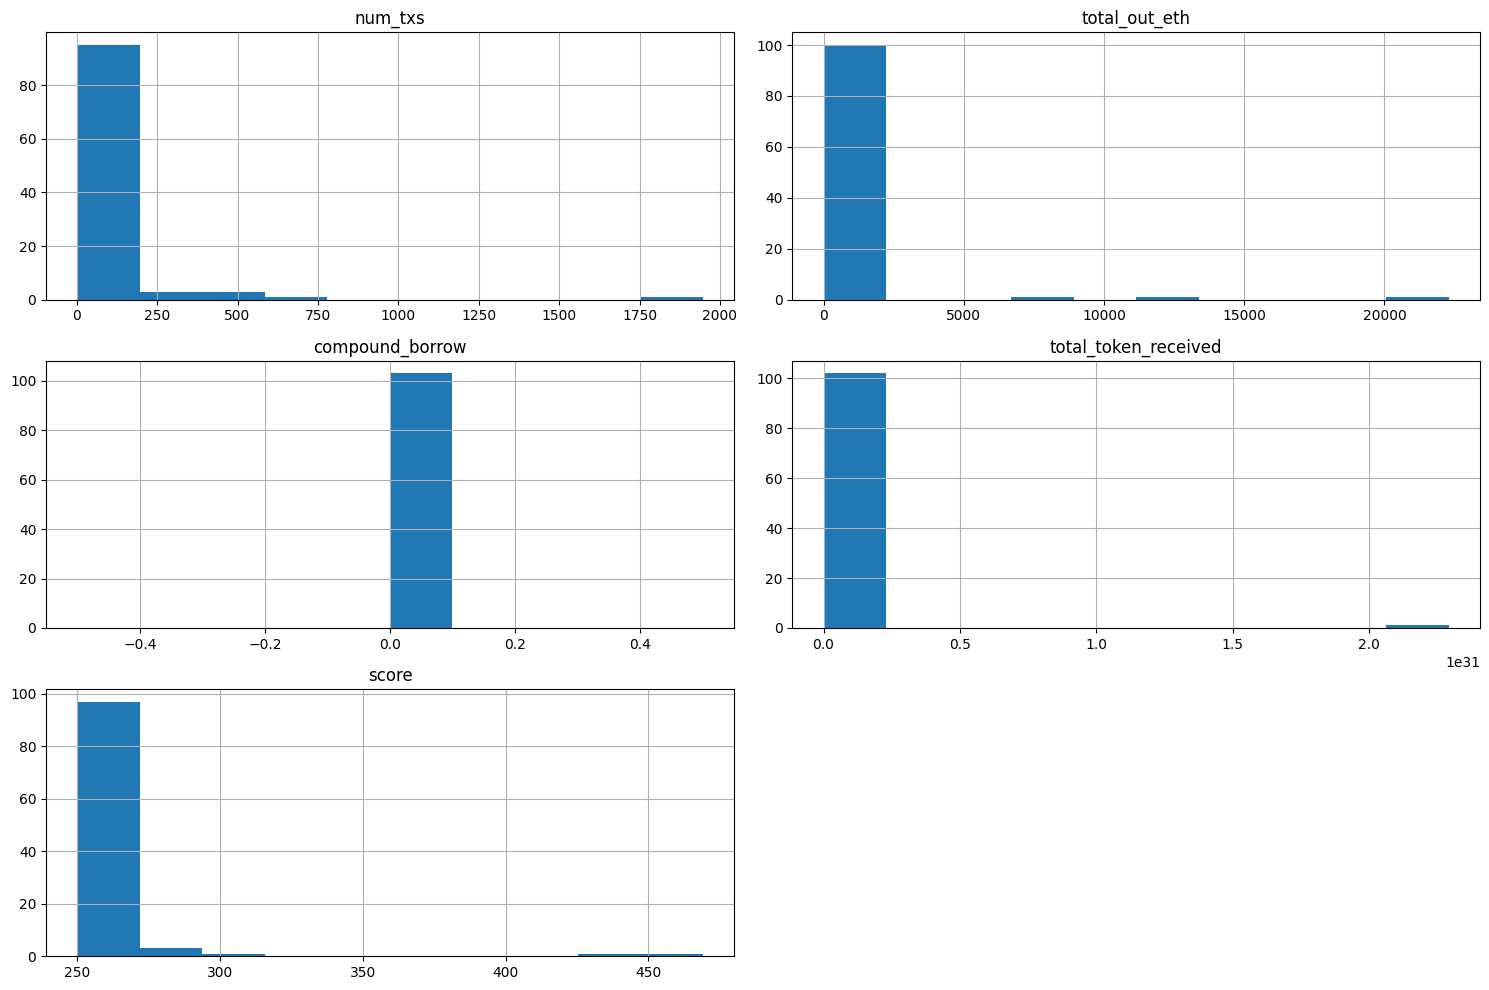

In [41]:
import matplotlib.pyplot as plt

key_features = ['num_txs', 'total_out_eth', 'compound_borrow', 'total_token_received', 'score']

df[key_features].hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In [42]:

relevant_existing_features = [
    "num_txs",
    "total_out_eth",
    "avg_tx_value_eth",
    "total_token_received",
]


potentially_relevant_zero_variance_features = [
    "compound_supply",
    "compound_borrow",
    "compound_collateral_ratio",
    "v3_collateral_usd",
    "v3_borrow_usd",
    "v3_health_score",
    "liquidation_count",
]



final_selected_features = relevant_existing_features + [
    "wallet_age_days",
    "total_gas_spent",
] + potentially_relevant_zero_variance_features

rationale = """
Rationale for Feature Selection:

Included Existing Features:
- num_txs: High correlation with score, indicates overall activity level.
- total_out_eth: High correlation with score, indicates value transacted out.
- avg_tx_value_eth: High correlation with score, indicates typical transaction size.
- total_token_received: Low correlation with current score, but conceptually relevant to wallet activity and potential involvement in token ecosystems.

Included Potentially Relevant Zero Variance Features (will be included in final list for model building):
- compound_supply, compound_borrow, compound_collateral_ratio: Critical for Compound V2 risk assessment. Currently zero variance in the dataset, but essential if wallets use V2.
- v3_collateral_usd, v3_borrow_usd, v3_health_score: Critical for Compound V3 risk assessment. Currently zero variance in the dataset, but essential if wallets use V3.
- liquidation_count: Direct indicator of past risk events. Currently zero variance in the dataset, but highly relevant if any liquidation events exist.

Included New Feasible Features (to be engineered):
- wallet_age_days: Provides context on the longevity and potential stability of the wallet's activity. Feasible to estimate from transaction data.
- total_gas_spent: A proxy for the complexity and frequency of interactions, particularly with smart contracts. Feasible to calculate from transaction data.

Excluded Brainstormed Features (for this iteration due to complexity/data limitations):
- Interaction with Specific Smart Contracts (beyond Compound): Requires external lists of contract addresses and more complex filtering logic.
- Incoming Transactions and Sources/Outbound Transaction Destinations: Requires sophisticated graph analysis or external data sources to map entities and assess risk, which is beyond the scope of this iteration.
- Specific Token Holdings/Balances: Obtaining accurate, real-time token balances for a wide range of tokens via API is challenging. total_token_received is a reasonable starting point.
"""

print("Final Selected Features:")
print(final_selected_features)
print("\n" + rationale)

Final Selected Features:
['num_txs', 'total_out_eth', 'avg_tx_value_eth', 'total_token_received', 'wallet_age_days', 'total_gas_spent', 'compound_supply', 'compound_borrow', 'compound_collateral_ratio', 'v3_collateral_usd', 'v3_borrow_usd', 'v3_health_score', 'liquidation_count']


Rationale for Feature Selection:

Included Existing Features:
- num_txs: High correlation with score, indicates overall activity level.
- total_out_eth: High correlation with score, indicates value transacted out.
- avg_tx_value_eth: High correlation with score, indicates typical transaction size.
- total_token_received: Low correlation with current score, but conceptually relevant to wallet activity and potential involvement in token ecosystems.

Included Potentially Relevant Zero Variance Features (will be included in final list for model building):
- compound_supply, compound_borrow, compound_collateral_ratio: Critical for Compound V2 risk assessment. Currently zero variance in the dataset, but essential 

In [43]:
# Define weights for the selected features
feature_weights = {
    "num_txs": 0.10,
    "total_out_eth": 0.15,
    "avg_tx_value_eth": 0.10,
    "total_token_received": 0.05,
    "compound_supply": 0.05,
    "compound_borrow": 0.15,
    "compound_collateral_ratio": 0.10,
    "v3_collateral_usd": 0.05,
    "v3_borrow_usd": 0.10,
    "v3_health_score": 0.05,
    "liquidation_count": 0.10,
    "wallet_age_days": 0.05,
    "total_gas_spent": 0.05,
}

# Ensure all features in weights exist in the DataFrame columns before scaling
selected_features = list(feature_weights.keys())
features_for_scaling = [feat for feat in selected_features if feat in df.columns]

# Re-apply MinMaxScaler to the selected features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_for_scaling])

# Calculate the new risk scores using the updated formula and weights
df["score"] = 0
for i, feature in enumerate(features_for_scaling):
    weight = feature_weights[feature]
    # Apply weights based on risk indication
    if feature in ["compound_supply", "compound_collateral_ratio", "v3_collateral_usd", "v3_health_score", "wallet_age_days"]:
         # For features where higher value means lower risk, use (1 - scaled_value)
         if feature == "compound_collateral_ratio":
             df["score"] += weight * (1 - scaled_features[:, i]) * 1000
         elif feature == "v3_health_score":
              df["score"] += weight * (1 - scaled_features[:, i]) * 1000
         elif feature == "wallet_age_days":
              df["score"] += weight * (1 - scaled_features[:, i]) * 1000
         elif feature in ["compound_supply", "v3_collateral_usd"]:
               df["score"] += weight * (1 - scaled_features[:, i]) * 1000
    else:
        # For features where higher value means higher risk
        df["score"] += weight * scaled_features[:, i] * 1000

df["score"] = df["score"].round().astype(int)

display(df[['wallet_id', 'score']].head())

,wallet_id,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,460
1,0x06b51c6882b27cb05e712185531c1f74996dd988,300
2,0x0795732aacc448030ef374374eaae57d2965c16c,300
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,276
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,299


In [44]:
# 1. Ensure missing features have placeholder columns
for feature in feature_weights.keys():
    if feature not in df.columns:
        df[feature] = 0

# 2. Create a list of features for scaling
features_for_scaling = list(feature_weights.keys())


scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_for_scaling])


df["score"] = 0

for i, feature in enumerate(features_for_scaling):
    weight = feature_weights[feature]
    if feature in ["compound_supply", "compound_collateral_ratio", "v3_collateral_usd", "v3_health_score", "wallet_age_days"]:
        df["score"] += weight * (1 - scaled_features[:, i]) * 1000
    else:
        df["score"] += weight * scaled_features[:, i] * 1000

df["score"] = df["score"].round().astype(int)

# 12. Display the 'wallet_id' and 'score' columns
display(df[['wallet_id', 'score']])

,wallet_id,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,460
1,0x06b51c6882b27cb05e712185531c1f74996dd988,300
2,0x0795732aacc448030ef374374eaae57d2965c16c,300
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,276
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,299
...,...,...
98,0xf60304b534f74977e159b2e159e135475c245526,300
99,0xf67e8e5805835465f7eba988259db882ab726800,300
100,0xf7aa5d0752cfcd41b0a5945867d619a80c405e52,300
101,0xf80a8b9cfff0febf49914c269fb8aead4a22f847,300


,score
count,103.000000
mean,301.213592
std,33.184171
min,253.000000
25%,295.500000
50%,300.000000
75%,300.000000
max,527.000000


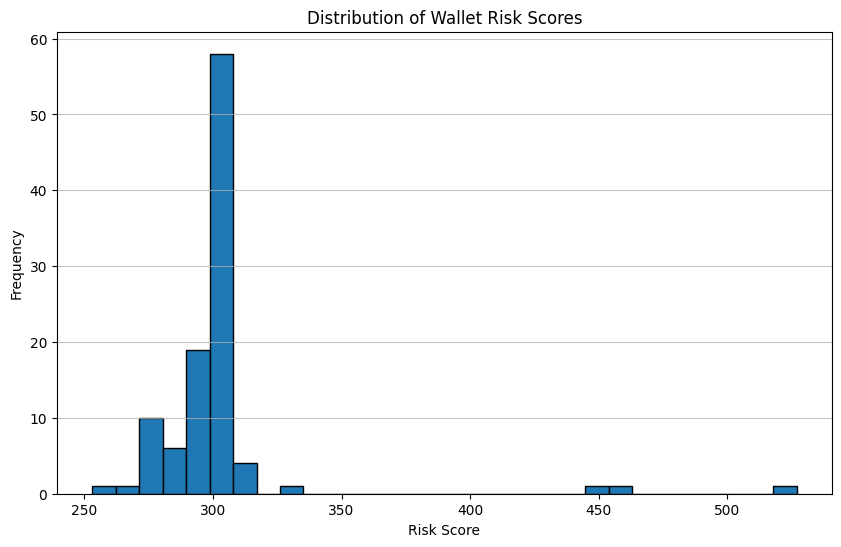

In [45]:
display(df['score'].describe())

plt.figure(figsize=(10, 6))
plt.hist(df['score'], bins=30, edgecolor='black')
plt.title('Distribution of Wallet Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

,score
count,103.000000
mean,475.378641
std,79.608985
min,384.000000
25%,462.000000
50%,467.000000
75%,468.000000
max,1000.000000


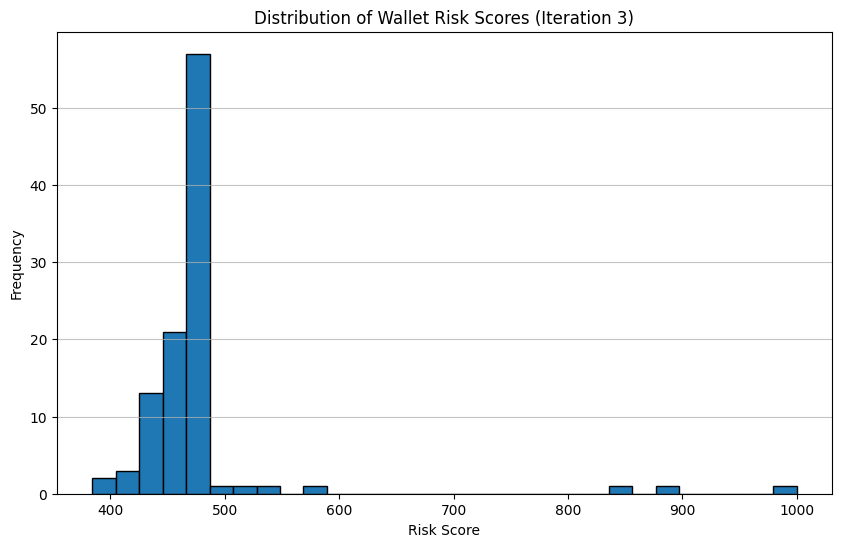

In [46]:
# Adjust feature weights to attempt to spread out the scores
feature_weights = {
    "num_txs": 0.20,
    "total_out_eth": 0.20,
    "avg_tx_value_eth": 0.10,
    "total_token_received": 0.05,
    "compound_supply": 0.05,
    "compound_borrow": 0.10,
    "compound_collateral_ratio": 0.05,
    "v3_collateral_usd": 0.05,
    "v3_borrow_usd": 0.10,
    "v3_health_score": 0.05,
    "liquidation_count": 0.05,
    "wallet_age_days": 0.05,
    "total_gas_spent": 0.00,
}

# Ensure all features in weights exist in the DataFrame columns before scaling
selected_features = list(feature_weights.keys())
features_for_scaling = [feat for feat in selected_features if feat in df.columns]

# Re-apply MinMaxScaler to the selected features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[features_for_scaling])

df["score"] = 0
for i, feature in enumerate(features_for_scaling):
    weight = feature_weights[feature]
    # Apply weights based on risk indication
    if feature in ["compound_supply", "compound_collateral_ratio", "v3_collateral_usd", "v3_health_score", "wallet_age_days"]:
         df["score"] += weight * (1 - scaled_features[:, i])
    else:
        # For features where higher value means higher risk
        df["score"] += weight * scaled_features[:, i]

# Scale the final score to a 0-1000 range
df["score"] = (df["score"] / df["score"].max()) * 1000
df["score"] = df["score"].round().astype(int)


# Evaluate the new score distribution
display(df['score'].describe())

plt.figure(figsize=(10, 6))
plt.hist(df['score'], bins=30, edgecolor='black')
plt.title('Distribution of Wallet Risk Scores (Iteration 3)')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [47]:
# Save the updated scores to a new CSV file
df[["wallet_id", "score"]].to_csv("wallet_risk_scores_improved.csv", index=False)
print("✅ Improved scores saved to 'wallet_risk_scores_improved.csv'")

✅ Improved scores saved to 'wallet_risk_scores_improved.csv'


In [48]:
df

,wallet_id,num_txs,total_out_eth,avg_tx_value_eth,compound_supply,compound_borrow,compound_collateral_ratio,v3_collateral_usd,v3_borrow_usd,v3_health_score,liquidation_count,total_token_received,wallet_age_days,total_gas_spent,score
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,1946,7494.162664,4.393655,0,0,1,0,0,1,0,2.133057e+11,2513.024005,27.953231,891
1,0x06b51c6882b27cb05e712185531c1f74996dd988,4,0.005702,0.006075,0,0,1,0,0,1,0,1.445326e+02,0.004896,0.013780,468
2,0x0795732aacc448030ef374374eaae57d2965c16c,3,0.000000,0.006200,0,0,1,0,0,1,0,1.439816e+02,0.022778,0.012985,467
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9,24,135.107495,8.407646,0,0,1,0,0,1,0,9.138462e+11,1879.461979,0.060257,425
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae,4,0.007405,0.006501,0,0,1,0,0,1,0,1.444973e+02,63.882245,0.012245,466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0xf60304b534f74977e159b2e159e135475c245526,10,0.000000,0.000000,0,0,1,0,0,1,0,2.491923e+05,44.358391,0.072650,467
99,0xf67e8e5805835465f7eba988259db882ab726800,3,0.000000,0.005333,0,0,1,0,0,1,0,1.436774e+02,7.088646,0.011010,467
100,0xf7aa5d0752cfcd41b0a5945867d619a80c405e52,3,0.000000,0.006200,0,0,1,0,0,1,0,1.443809e+02,0.002812,0.004935,467
101,0xf80a8b9cfff0febf49914c269fb8aead4a22f847,3,0.000000,0.133668,0,0,1,0,0,1,0,4.061947e+02,0.662836,0.005052,468
